**Подключаем библиотеки и датасет**

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

train_df = pd.read_csv('train.csv')

**Выводим первые строки загруженного датасета для ознакомления с его структурой. Также выводим информацию о типах данных, количестве пропусков и столбцов. Подсчитываем и выводим количество дубликатов в датасете.**

In [62]:
print(train_df.head())
print(train_df.info())
print("Количество дубликатов:", train_df.duplicated().sum())

  ApplicationDate   Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
0      2010-06-26  27.0       66829.0        549.0     17290.0          60.0   
1      1996-09-23  55.0      172147.0        850.0     16110.0          36.0   
2      2015-01-19  51.0      300000.0        850.0     38436.0          36.0   
3      1981-05-12  25.0       34683.0        847.0     19186.0          48.0   
4      1995-05-07  55.0      300000.0        850.0     30437.0          48.0   

  MaritalStatus  NumberOfDependents HomeOwnershipStatus  MonthlyDebtPayments  \
0      Divorced                 1.0                Rent               1095.0   
1       Widowed                 1.0            Mortgage                211.0   
2       Married                 0.0            Mortgage                546.0   
3       Married                 0.0               Other                153.0   
4        Single                 2.0                Rent                562.0   

   ...  EmploymentStatus  EducationLev

**Удаляем дубликаты и пропуски из датасета, очищая его для дальнейшего анализа.**

In [63]:
train_df = train_df.drop_duplicates()
train_df = train_df.dropna()

**Выводим статистическое описание столбца RiskScore, включая такие показатели, как среднее, стандартное отклонение, минимальное и максимальное значения, квартили.**

In [64]:
train_df['RiskScore'].describe()

count    9.529000e+03
mean    -3.458380e+04
std      1.437496e+06
min     -9.999999e+06
25%      3.249476e+01
50%      4.401980e+01
75%      6.526522e+01
max      1.000000e+07
Name: RiskScore, dtype: float64

**Вычисляем квартильные значения (Q1 и Q3) и интерквартильный размах (IQR) для столбца RiskScore. Определяем границы для выявления выбросов и удаляем строки с выбросами. После этого снова выводим статистическое описание очищенного столбца RiskScore.**

In [65]:
Q1 = train_df['RiskScore'].quantile(0.25)
Q3 = train_df['RiskScore'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train_df = train_df[(train_df['RiskScore'] >= lower_bound) & (train_df['RiskScore'] <= upper_bound)]
train_df['RiskScore'].describe()

count    9332.000000
mean       48.312511
std        17.243078
min        14.841417
25%        32.693275
50%        44.127496
75%        65.059406
max        97.597249
Name: RiskScore, dtype: float64

**Определяем категориальные признаки в датасете, выбирая столбцы с типами данных object и category. Выводим список этих признаков для дальнейшей работы.**

In [66]:
categorical_features = train_df.select_dtypes(include=['object', 'category']).columns
categorical_features

Index(['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus',
       'LoanPurpose', 'EmploymentStatus', 'EducationLevel'],
      dtype='object')

**Преобразуем категориальные признаки в наборы индикаторных переменных с помощью функции get_dummies. После этого создаём список всех признаков датасета, исключая целевой столбец RiskScore.**

In [67]:
train_df = pd.get_dummies(train_df, columns=categorical_features)

**Определяем числовые признаки, исключая целевую переменную RiskScore, и выводим их для нормализации. Инициализируем StandardScaler и обучаем его на выбранных числовых признаках, затем нормализуем эти признаки в тренировочном датасете.**

In [68]:
numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

target_variable = 'RiskScore'
if target_variable in numerical_features:
    numerical_features.remove(target_variable)

print("Числовые признаки для нормализации:", numerical_features)

scaler = StandardScaler()

scaler.fit(train_df[numerical_features])

train_df[numerical_features] = scaler.transform(train_df[numerical_features])

Числовые признаки для нормализации: ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved']


**Построим матрицу корреляции**

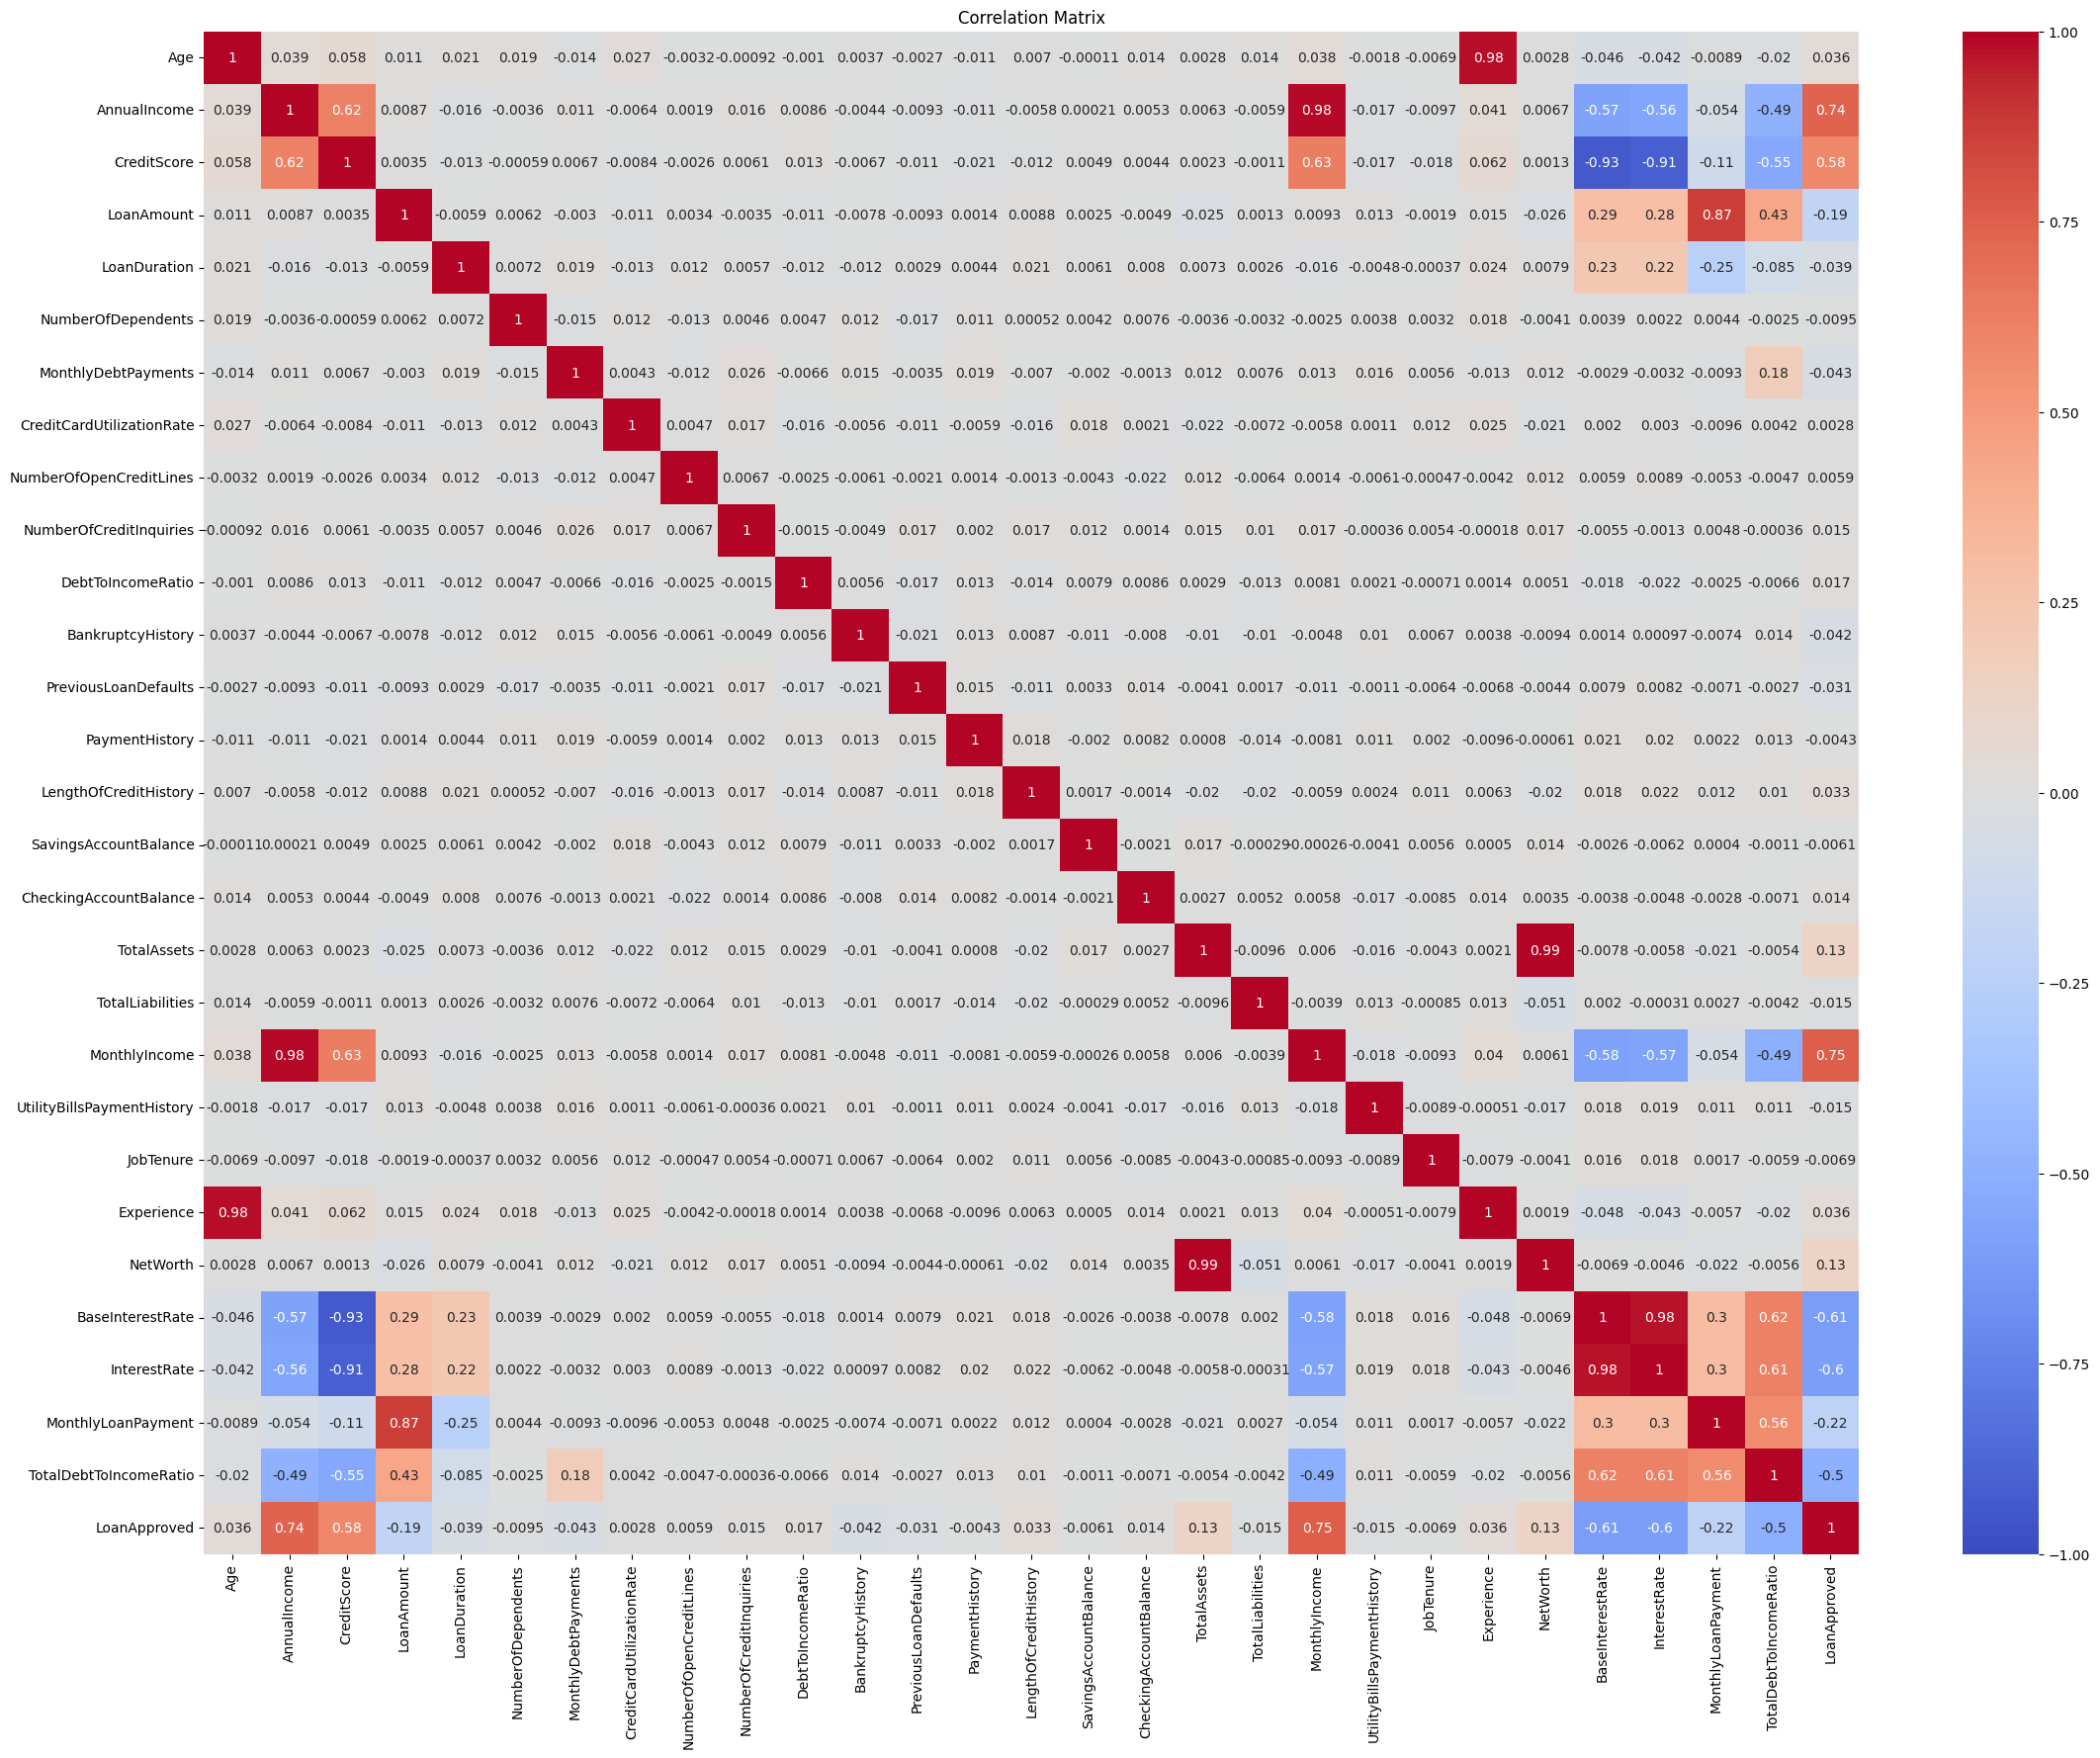

In [69]:
correlation_matrix = train_df[numerical_features].corr()


plt.figure(figsize=(27, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

**Удалим признаки, в которых корреляция > 0.8**

In [70]:
columns_to_remove = set()

# Проходим по корреляционной матрице и добавляем сильно коррелирующие признаки в список
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            columns_to_remove.add(colname)

# Удаляем признаки с высокой корреляцией
train_df = train_df.drop(columns=columns_to_remove)

print("Удаленные признаки:", columns_to_remove)

Удаленные признаки: {'MonthlyLoanPayment', 'Experience', 'NetWorth', 'MonthlyIncome', 'BaseInterestRate', 'InterestRate'}


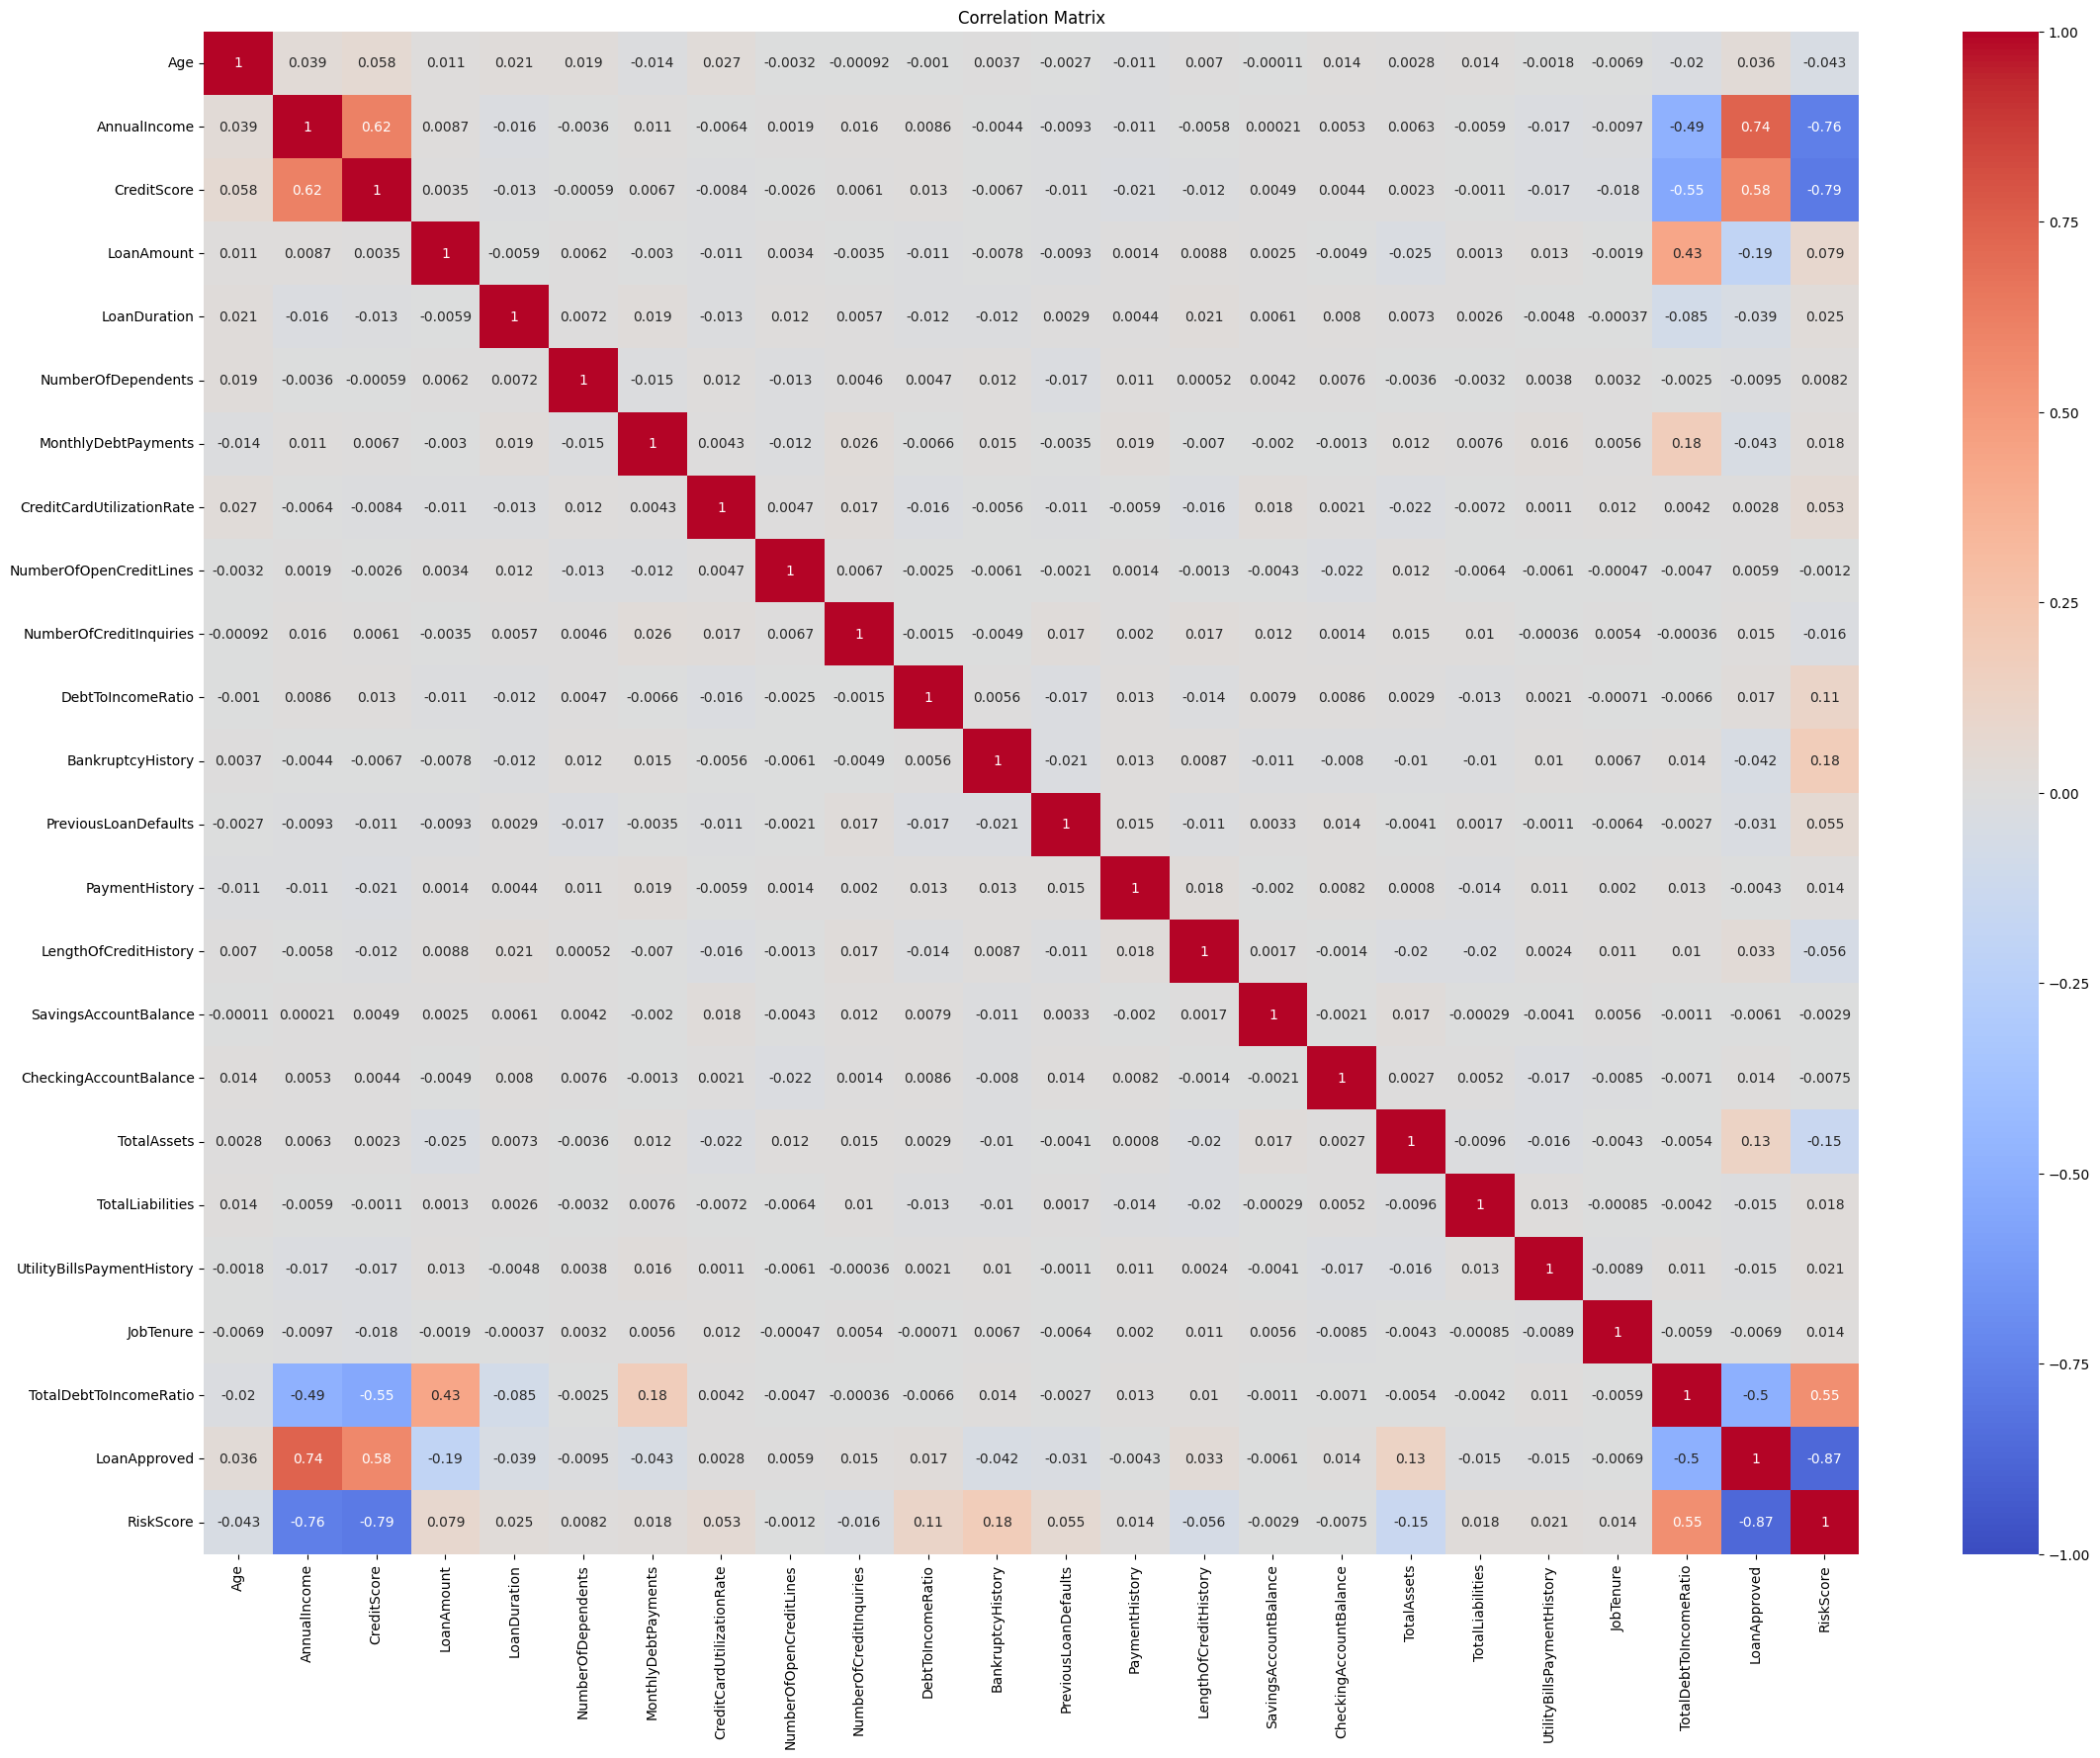

In [71]:
correlation_matrix = train_df[train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()].corr()


plt.figure(figsize=(27, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

**Выводим информацию о датасете**

In [72]:
train_df.info()

train_df

<class 'pandas.core.frame.DataFrame'>
Index: 9332 entries, 0 to 9999
Columns: 9377 entries, Age to EducationLevel_Master
dtypes: bool(9353), float64(24)
memory usage: 85.0 MB


,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,...,LoanPurpose_Home,LoanPurpose_Other,EmploymentStatus_Employed,EmploymentStatus_Self-Employed,EmploymentStatus_Unemployed,EducationLevel_Associate,EducationLevel_Bachelor,EducationLevel_Doctorate,EducationLevel_High School,EducationLevel_Master
0,-1.111860,-0.558666,-0.736675,-0.458262,0.271045,-0.399683,1.088754,-0.834293,-0.592693,0.020501,...,False,False,True,False,False,True,False,False,False,False
1,1.305009,0.349116,0.981312,-0.501464,-0.712006,-0.399683,-0.667339,-0.685576,-0.017923,-0.991767,...,True,False,True,False,False,False,False,False,True,False
2,0.959742,1.451138,0.981312,0.315946,-0.712006,-1.105025,-0.001851,1.001318,-0.017923,-0.991767,...,False,False,True,False,False,False,True,False,False,False
3,-1.284494,-0.835746,0.964189,-0.388844,-0.220481,-1.105025,-0.782558,-0.605538,2.281157,-0.991767,...,False,False,True,False,False,False,False,False,True,False
4,1.305009,1.451138,0.981312,0.023083,-0.220481,0.305658,0.029933,-0.072460,-0.017923,0.020501,...,False,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,-0.766593,1.451138,0.981312,-0.560301,0.271045,0.305658,-0.718989,-1.433705,0.556847,-0.991767,...,False,False,True,False,False,False,False,True,False,False
9995,-1.111860,-1.005403,-1.809704,-0.377165,-0.712006,-0.399683,0.149125,0.780542,-0.592693,0.020501,...,False,False,True,False,False,False,False,False,True,False
9996,0.787109,0.460609,-0.599693,-0.818638,1.254095,-1.105025,0.792761,-1.189089,-1.742233,-0.991767,...,False,False,True,False,False,False,False,False,True,False
9997,1.305009,1.422935,0.981312,0.525589,1.254095,0.305658,-0.134949,0.557179,1.706387,-0.991767,...,False,False,True,False,False,False,False,False,True,False


**Разделяем датасет на признаки (X) и целевую переменную (y), удаляя столбец RiskScore из признаков.**

In [73]:
X = train_df.drop('RiskScore', axis=1)
y = train_df['RiskScore']

**Разделяем данные на обучающую и валидационную выборки, используя 80% для обучения и 20% для валидации, с фиксированным значением random_state для воспроизводимости.**

In [74]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**Обучаем модель Ridge с параметром alpha=1 на тренировочных данных. Вычисляем и выводим среднюю квадратичную ошибку (MSE) на обучающей выборке.**

In [75]:
# Попыталась сделать на LinearRegression, потом изменила на Ridge, функция ошибок уменьшилась, оставляем второй вариант

# model = LinearRegression()

# model.fit(X_train, y_train)


reg = Ridge(alpha=1).fit(X_train, y_train)

pred_train = reg.predict(X_train)
print("MSE on train", mean_squared_error(y_train, pred_train))

MSE on train 4.748978566424941


In [76]:
# from sklearn.metrics import mean_squared_error, r2_score

# y_pred = model.predict(X_valid)

# mse = mean_squared_error(y_valid, y_pred)
# r2 = r2_score(y_valid, y_pred)

# print("MSE на валидационной выборке:", mse)
# print("R^2 на валидационной выборке:", r2)

In [77]:
test_df = pd.read_csv('test.csv')
test_df

,ID,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,...,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved
0,0,1979-01-03,49,207095,850,14458,60,Single,0,Rent,...,6,Employed,High School,23,10626,0.104458,0.125350,325.532336,0.040650,1
1,1,2006-04-10,28,64653,674,65491,48,Single,2,Own,...,3,Employed,High School,3,299024,0.233491,0.260561,2210.247757,0.454410,0
2,2,2013-11-28,41,300000,768,16811,60,Single,1,Own,...,3,Employed,High School,19,6979,0.147811,0.154571,403.977431,0.034919,1
3,3,1995-08-24,50,300000,850,48737,36,Divorced,0,Mortgage,...,3,Self-Employed,Bachelor,26,8438,0.118737,0.099712,1571.946906,0.085558,1
4,4,1980-06-15,35,300000,672,51916,60,Single,6,Mortgage,...,7,Employed,Associate,12,436216,0.230916,0.237727,1486.675235,0.063707,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,1993-03-19,40,300000,850,12696,60,Married,1,Other,...,3,Self-Employed,Master,19,10957,0.102696,0.094445,266.295150,0.028012,1
4996,4996,2015-09-27,39,75014,572,49380,48,Married,0,Mortgage,...,3,Employed,Master,16,7587,0.268380,0.302377,1784.809960,0.301033,0
4997,4997,1993-10-04,43,15000,454,32810,72,Divorced,1,Other,...,6,Employed,Bachelor,17,403922,0.330810,0.283165,951.731011,0.992585,0
4998,4998,1981-05-10,53,98467,850,28446,96,Single,1,Own,...,6,Self-Employed,High School,30,5652,0.148446,0.163516,532.966868,0.090910,0


**Удаляем дубликаты и пропуски из тестового датасета. Преобразуем категориальные признаки в индикаторные переменные с помощью функции get_dummies. Приводим тестовый датасет к тем же столбцам, что и в тренировочном, заполняя отсутствующие значения нулями. Применяем масштабирование к числовым признакам с помощью ранее обученного StandardScaler.**

In [83]:
test_df = test_df.drop_duplicates().dropna()

categorical_features = test_df.select_dtypes(include=['object', 'category']).columns
test_df = pd.get_dummies(test_df, columns=categorical_features)
test_df = test_df.drop(columns=columns_to_remove, errors='ignore')
test_df = test_df.reindex(columns=X.columns, fill_value=0)


numerical_features = test_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
test_df[numerical_features] = scaler.transform(test_df[numerical_features])
numerical_features

['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'UtilityBillsPaymentHistory', 'JobTenure', 'TotalDebtToIncomeRatio', 'LoanApproved', 'RiskScore', 'ApplicationDate_1979-01-01', 'ApplicationDate_1979-01-04', 'ApplicationDate_1979-01-09', 'ApplicationDate_1979-01-11', 'ApplicationDate_1979-01-13', 'ApplicationDate_1979-01-15', 'ApplicationDate_1979-01-18', 'ApplicationDate_1979-01-20', 'ApplicationDate_1979-01-21', 'ApplicationDate_1979-01-24', 'ApplicationDate_1979-01-27', 'ApplicationDate_1979-01-28', 'ApplicationDate_1979-01-29', 'ApplicationDate_1979-01-30', 'ApplicationDate_1979-01-31', 'ApplicationDate_1979-02-01', 'ApplicationDate_1979-02-02', 

In [88]:
test_df = test_df.drop_duplicates().dropna()

categorical_features = test_df.select_dtypes(include=['object', 'category']).columns
test_df = pd.get_dummies(test_df, columns=categorical_features)
test_df = test_df.drop(columns=columns_to_remove, errors='ignore')
test_df = test_df.reindex(columns=X.columns, fill_value=0)

scaler = StandardScaler()

scaler.fit(test_df[numerical_features])
numerical_features = test_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
test_df[numerical_features] = scaler.transform(test_df[numerical_features])
numerical_features

['Age',
 'AnnualIncome',
 'CreditScore',
 'LoanAmount',
 'LoanDuration',
 'NumberOfDependents',
 'MonthlyDebtPayments',
 'CreditCardUtilizationRate',
 'NumberOfOpenCreditLines',
 'NumberOfCreditInquiries',
 'DebtToIncomeRatio',
 'BankruptcyHistory',
 'PreviousLoanDefaults',
 'PaymentHistory',
 'LengthOfCreditHistory',
 'SavingsAccountBalance',
 'CheckingAccountBalance',
 'TotalAssets',
 'TotalLiabilities',
 'UtilityBillsPaymentHistory',
 'JobTenure',
 'TotalDebtToIncomeRatio',
 'LoanApproved',
 'ApplicationDate_1979-01-01',
 'ApplicationDate_1979-01-04',
 'ApplicationDate_1979-01-09',
 'ApplicationDate_1979-01-11',
 'ApplicationDate_1979-01-13',
 'ApplicationDate_1979-01-15',
 'ApplicationDate_1979-01-18',
 'ApplicationDate_1979-01-20',
 'ApplicationDate_1979-01-21',
 'ApplicationDate_1979-01-24',
 'ApplicationDate_1979-01-27',
 'ApplicationDate_1979-01-28',
 'ApplicationDate_1979-01-29',
 'ApplicationDate_1979-01-30',
 'ApplicationDate_1979-01-31',
 'ApplicationDate_1979-02-01',
 'App

In [79]:
# pred = model.predict(test_df)

In [89]:
out = pd.DataFrame({
    'ID' : test_df.index,
    'RiskScore' : reg.predict(test_df)
})
out.to_csv('submission.csv', index=False)